In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Extracting the Data ; Run only if restarting runtime or running first time
!tar -xvf "/content/drive/My Drive/image_data/image_data.tar.gz"

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Data(object):
  
  '''
  A class to load and setup data transformers
  '''
  
  def __init__(self,batch_size=75,test_size=0.2):
    self.batch_size = batch_size
    self.test_size = test_size
    self.transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      
    ])
    
  def load_data(self):

    train_data = datasets.ImageFolder('image_data',transform=self.transform)

    num_train = len(train_data)
    print('Total Data Points {}'.format(num_train))
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(self.test_size*num_train))
    train_idx,test_idx = indices[split:],indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    self.train_loader = torch.utils.data.DataLoader(train_data,batch_size=self.batch_size,sampler=train_sampler)
    self.test_loader = torch.utils.data.DataLoader(train_data,batch_size=self.batch_size,sampler=test_sampler)

    self.classes = ['fake','real']

    return self.train_loader,self.test_loader

  def plot(self):
    
    '''
    Plots a single Image and label
    '''
    images,labels = (iter(self.train_loader)).next()
    print(labels.shape)
    image,truth = images[0],labels[0]
    
    ## convert image to numpy
    image = image.numpy()
    image = image/2 + 0.5 ## unnormalize
    print('Shape of Image from Loader {}'.format(image.shape))
    image = np.transpose(image,(1,2,0))
    plt.imshow(image)
    plt.title(self.classes[truth])
    plt.show()    

In [3]:
data = Data()
train_loader,test_loader = data.load_data()

Total Data Points 21981


torch.Size([75])
Shape of Image from Loader (3, 256, 256)


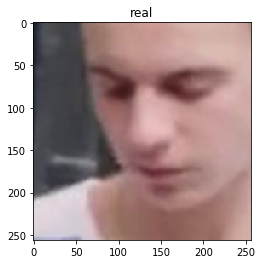

In [4]:
data.plot()

In [5]:
## Define the Model

import torch.nn as nn
import torch.nn.functional as F

In [6]:
class MesoInception4(nn.Module):
  
  def __init__(self):
    super(MesoInception4,self).__init__()

    ## 1,4,4,2 -> inception layer 1

    self.inception_1_conv_1_1  = nn.Conv2d(3,1,1,padding=0)

    self.inception_1_conv_2_1  = nn.Conv2d(3,4,1,padding=0)
    self.inception_1_conv_2_2  = nn.Conv2d(4,4,3,padding=1)

    self.inception_1_conv_3_1  = nn.Conv2d(3,4,1,padding=0)
    self.inception_1_conv_3_2  = nn.Conv2d(4,4,3,padding=2,dilation=2)

    self.inception_1_conv_4_1 = nn.Conv2d(3,2,1,padding=0)
    self.inception_1_conv_4_2 = nn.Conv2d(2,2,3,dilation=3,padding=3)

    self.bn_1 = nn.BatchNorm2d(11)

    ## 2,4,4,2 -> inception layer 2

    self.inception_2_conv_1_1  = nn.Conv2d(11,2,1,padding=0)

    self.inception_2_conv_2_1  = nn.Conv2d(11,4,1,padding=0)
    self.inception_2_conv_2_2  = nn.Conv2d(4,4,3,padding=1)

    self.inception_2_conv_3_1  = nn.Conv2d(11,4,1,padding=0)
    self.inception_2_conv_3_2  = nn.Conv2d(4,4,3,padding=2,dilation=2)

    self.inception_2_conv_4_1 = nn.Conv2d(11,2,1,padding=0)
    self.inception_2_conv_4_2 = nn.Conv2d(2,2,3,dilation=3,padding=3)

    self.bn_2 = nn.BatchNorm2d(12)


    self.conv_1 = nn.Conv2d(12,16,5,padding=2)     ## inpute_channel,output_channel,kernel_size
    self.relu = nn.ReLU(inplace=True)
    self.leakyrelu = nn.LeakyReLU(0.1)
    self.bn_3 = nn.BatchNorm2d(16)
    self.max_pool_1 = nn.MaxPool2d((2,2))

    self.conv_2 = nn.Conv2d(16,16,5,padding=2)
    self.max_pool_2 = nn.MaxPool2d((4,4))

    self.dropout = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(16*8*8,16)
    self.fc2 = nn.Linear(16,2)

  def inception_module_1(self,x):
    ## Gets input for module 1 
    ## returns output of module 1
    x1 =  self.relu(self.inception_1_conv_1_1(x))

    x2 =  self.relu(self.inception_1_conv_2_1(x))
    x2 =  self.relu(self.inception_1_conv_2_2(x2)) 

    x3 =  self.relu(self.inception_1_conv_3_1(x))
    x3 =  self.relu(self.inception_1_conv_3_2(x3))

    x4 =  self.relu(self.inception_1_conv_4_1(x))
    x4 =  self.relu(self.inception_1_conv_4_2(x4))

    y = torch.cat((x1,x2,x3,x4),1)
    y = self.bn_1(y)
    y = self.max_pool_1(y)

    return y

  def inception_module_2(self,x):
    ## Gets input for module 2 
    ## returns output of module 2
    x1 =  self.relu(self.inception_2_conv_1_1(x))

    x2 =  self.relu(self.inception_2_conv_2_1(x))
    x2 =  self.relu(self.inception_2_conv_2_2(x2))

    x3 =  self.relu(self.inception_2_conv_3_1(x))
    x3 =  self.relu(self.inception_2_conv_3_2(x3))

    x4 =  self.relu(self.inception_2_conv_4_1(x))
    x4 =  self.relu(self.inception_2_conv_4_2(x4))

    y = torch.cat((x1,x2,x3,x4),1)
    y = self.bn_2(y)
    y = self.max_pool_1(y)
    
    return y

  
  def forward(self,x):
    '''
    Forward pass of the model
    '''
    x = self.inception_module_1(x)

    x = self.inception_module_2(x)
    
    x = self.conv_1(x)
    x = self.relu(x)
    x = self.bn_3(x)
    x = self.max_pool_1(x)

    x = self.conv_2(x)
    x = self.relu(x)
    x = self.bn_3(x)
    x = self.max_pool_2(x)
    
    x = x.view(-1,16*8*8) ## Flatten the layer for dense operations

    
    x = self.dropout(x)
    x = self.leakyrelu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    
    return x
  

In [7]:
model = MesoInception4()

print(model)

MesoInception4(
  (inception_1_conv_1_1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (inception_1_conv_2_1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (inception_1_conv_2_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inception_1_conv_3_1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (inception_1_conv_3_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (inception_1_conv_4_1): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1))
  (inception_1_conv_4_2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
  (bn_1): BatchNorm2d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception_2_conv_1_1): Conv2d(11, 2, kernel_size=(1, 1), stride=(1, 1))
  (inception_2_conv_2_1): Conv2d(11, 4, kernel_size=(1, 1), stride=(1, 1))
  (inception_2_conv_2_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inception_2_conv_3_1): Conv2d(11, 4, kernel_size=(1

In [8]:
import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)

In [12]:
model = model.cuda()
n_epochs = 30
for epoch in range(1,n_epochs+1):
  
  ## Train loss for this epoch
  train_loss = 0.0
  total,correct = 0,0
  for batch_idx,(data,target) in enumerate(train_loader):
    data,target = Variable(data.cuda()),Variable(target.cuda())
    ## clear the optimizer
    optimizer.zero_grad()
    
    ## get the output
    output = model(data)
    
    ## get the loss
    loss = criterion(output,target)
    
    ## make a backward pass
    loss.backward()
    
    ## optimize
    optimizer.step()

    _,pred = torch.max(output.data,1)
    total += target.size(0) ## add batch_size
    correct += (pred == target).sum().item()

    acc = 100*(correct/total)
    
    ## update loss
    train_loss += loss.item()*data.size(0) ## Loss*no of elements in batch
   
  train_loss = train_loss/len(train_loader.sampler)

  print('Epochs: {} \tTraining Loss: {:.6f}  \tAccuracy:  {}'.format(epoch,train_loss,acc))

/home/ruchit/.local/lib/python3.5/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epochs: 1 	Training Loss: 0.637020  	Accuracy:  63.901052032982655
Epochs: 2 	Training Loss: 0.522081  	Accuracy:  77.6741541086153
Epochs: 3 	Training Loss: 0.467544  	Accuracy:  83.78731873756043


KeyboardInterrupt: 

In [13]:
def evaluate(loader,model_e):
    total,correct = 0,0
    model_e.eval()
    for data in loader:
        images,target = data
        images,target = images.cuda(),target.cuda()
        outputs = model_e(images)
        _,pred = torch.max(outputs.data,1)
        total += target.size(0) ## add batch_size
        correct += (pred == target).sum().item()
    return 100*(correct/total)

In [ ]:
## Save the Model:

torch.save(model.state_dict(),'drive/My /MesoInceptionNaive.pt')

In [ ]:
## Load the model

net = MesoInception4()
net.load_state_dict(torch.load('drive/My Drive/deepFake_models/MesoInceptionNaive.pt'))
net = net.cuda()

In [ ]:
evaluate(test_loader,net)